<center><img src="slides/road_detection_unet.png"></center>

## Input Data

This notebook uses **satellite imagery** and **feature layers** of road networks as inputs. 

In [1]:
%matplotlib inline

from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [4]:
PATH = Path('data/paci/PACIPrep/')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64

In [ ]:
ims = [open_image(f) for f in sorted(list((PATH/VAL_DN).glob('**/*.jpg')))[:16]]

im_masks = [open_image(f) for f in sorted(list((PATH/MASKS_DN).glob('**/*.png')))[:16]]

In [8]:
ims = [open_image(f) for f in sorted(list((PATH/TRAIN_DN).glob('**/*.jpg')))[:16]]

im_masks = [open_image(f) for f in sorted(list((PATH/MASKS_DN).glob('**/*.png')))[:16]]

## Visualize input data

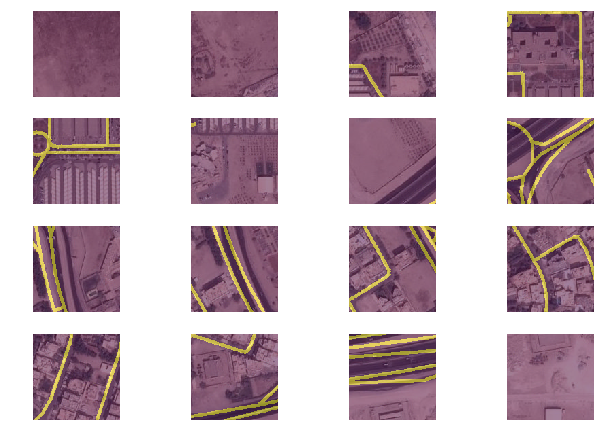

In [9]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

# Use U-Net model for training

<center><img src="imgs/unet-roads.JPG"></center>

In [10]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [11]:
x_names = np.array([f.relative_to(PATH) for f in sorted(list((PATH/TRAIN_DN).glob('**/*.jpg')))])
y_names = np.array([f.relative_to(PATH) for f in sorted(list((PATH/MASKS_DN).glob('**/*.png')))])

In [12]:
x_names[:10]

array([PosixPath('train-128/10240_28928.jpg'), PosixPath('train-128/10240_29184.jpg'),
       PosixPath('train-128/10240_29440.jpg'), PosixPath('train-128/10240_29696.jpg'),
       PosixPath('train-128/10240_29952.jpg'), PosixPath('train-128/10240_30208.jpg'),
       PosixPath('train-128/10240_30464.jpg'), PosixPath('train-128/10240_30720.jpg'),
       PosixPath('train-128/10240_30976.jpg'), PosixPath('train-128/10240_31232.jpg')], dtype=object)

In [13]:
y_names[:10]

array([PosixPath('train_masks-128/10240_28928.png'), PosixPath('train_masks-128/10240_29184.png'),
       PosixPath('train_masks-128/10240_29440.png'), PosixPath('train_masks-128/10240_29696.png'),
       PosixPath('train_masks-128/10240_29952.png'), PosixPath('train_masks-128/10240_30208.png'),
       PosixPath('train_masks-128/10240_30464.png'), PosixPath('train_masks-128/10240_30720.png'),
       PosixPath('train_masks-128/10240_30976.png'), PosixPath('train_masks-128/10240_31232.png')],
      dtype=object)

In [14]:
len(y_names)

10424

In [15]:
N = len(y_names)//16//5*16

In [16]:
N

2080

In [17]:
N = len(y_names)//16//5*16
val_idxs = list(range(N))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [18]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)] #, tfm_y=TfmType.CLASS)]

In [19]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [20]:
x,y = next(iter(md.trn_dl))

In [21]:
x.shape,y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

In [27]:
f = resnet34
cut,lr_cut = model_meta[f]

In [28]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [29]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [30]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [31]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [32]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [33]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [34]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [35]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [36]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [37]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 64, 64]),
 torch.Size([3, 64, 32, 32]),
 torch.Size([3, 128, 16, 16]),
 torch.Size([3, 256, 8, 8])]

In [38]:
learn.freeze_to(1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 110/131 [00:37<00:07,  2.92it/s, loss=1.72] 

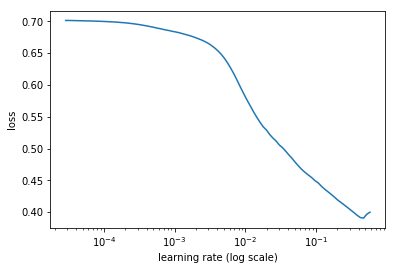

In [39]:
learn.lr_find()
learn.sched.plot()

In [41]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/100, lr/10, lr])

In [42]:
learn.fit(lr, 1, wds=wd, cycle_len=8, use_clr=(5,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

  8%|▊         | 10/131 [00:06<01:16,  1.58it/s, loss=0.564]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.215885   0.213651   0.920436   0.370096  
    1      0.201648   0.19956    0.923197   0.100281         
    2      0.195118   0.202923   0.923351   0.291064         
    3      0.192104   0.192736   0.92371    0.122995         
    4      0.186759   0.192059   0.924259   0.215254         
    5      0.18338    0.196297   0.924215   0.219086         
    6      0.177838   0.194876   0.924565   0.257335         
    7      0.174588   0.197581   0.924737   0.246107         



[array([0.19758]), 0.9247367272010216, 0.2461074790999592]

In [43]:
learn.save('128urn-tmp')

In [44]:
learn.fit(lr, 1, wds=wd, cycle_len=8, use_clr=(5,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.176641   0.204586   0.924031   0.166057  
    1      0.180558   0.203833   0.924006   0.186187         
    2      0.178211   0.19773    0.925282   0.324328         
    3      0.174514   0.195469   0.924368   0.263952         
    4      0.172634   0.198886   0.92484    0.289936         
    5      0.165118   0.20441    0.925338   0.277468         
    6      0.161011   0.198353   0.924981   0.323013         
    7      0.155749   0.201035   0.925879   0.340005         



[array([0.20103]), 0.9258790529691256, 0.3400047286733845]

In [46]:
learn.fit(lr, 1, wds=wd, cycle_len=8, use_clr=(5,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.151234   0.220779   0.924309   0.352041  
    1      0.159785   0.23133    0.925712   0.3023           
    2      0.156762   0.237157   0.924165   0.329616         
    3      0.153375   0.205624   0.926451   0.327946         
    4      0.148064   0.210161   0.924951   0.370091         
    5      0.144102   0.209434   0.924412   0.369909         
    6      0.140219   0.22055    0.924545   0.368466         
    7      0.134842   0.213295   0.925362   0.370175         



[array([0.2133]), 0.9253615452693059, 0.3701750139132381]

In [47]:
learn.load('128urn-tmp')

In [48]:
learn.unfreeze()
learn.bn_freeze(True)

In [49]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=20, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.165613   0.195224   0.925515   0.326148  
    1      0.167884   0.197713   0.926089   0.349545         
    2      0.165887   0.200858   0.924567   0.280257         
    3      0.165097   0.193986   0.925379   0.32928          
    4      0.160798   0.192334   0.925513   0.322605         
    5      0.159622   0.195419   0.925376   0.359799         
    6      0.160515   0.197333   0.925615   0.359716         
    7      0.157028   0.205476   0.925545   0.284834         
    8      0.154127   0.214337   0.925936   0.297582         
    9      0.151528   0.200558   0.926023   0.341301         
    10     0.151408   0.209505   0.925758   0.344268         
    11     0.14955    0.205166   0.926471   0.373066         
    12     0.146841   0.205546   0.92597    0.361625         
    13     0.144968   0.216401   0.926198   0.361169         
    14     0.144719   0.208139   0.925973   0.362574         
    15     0.14

[array([0.21665]), 0.9262118119459886, 0.36447371264150447]

In [50]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=20, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.139214   0.220109   0.926168   0.36897   
    1      0.143614   0.207076   0.92503    0.362829         
    2      0.142587   0.202758   0.925343   0.349754         
    3      0.142219   0.212863   0.925364   0.371103         
    4      0.140111   0.215327   0.925908   0.39847          
    5      0.137871   0.211677   0.92575    0.338438         
    6      0.135454   0.220189   0.925685   0.376188         
    7      0.132996   0.220511   0.926985   0.391148         
    8      0.134803   0.221681   0.925156   0.368415         
    9      0.130855   0.235531   0.9265     0.38212          
    10     0.128595   0.236081   0.924994   0.374557         
    11     0.12754    0.238166   0.925541   0.355534         
    12     0.124814   0.247664   0.926493   0.382534         
    13     0.12388    0.233979   0.925374   0.380929         
    14     0.122823   0.24047    0.925193   0.389975         
    15     0.11

[array([0.24756]), 0.9258800213153545, 0.3789144551220648]

In [63]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=20,use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.165809   0.203733   0.92503    0.247529  
    1      0.167293   0.198992   0.924654   0.216658         
    2      0.165979   0.198399   0.924118   0.32835          
    3      0.163736   0.206749   0.924815   0.275263         
    4      0.162423   0.194736   0.92496    0.301101         
    5      0.160225   0.19429    0.925257   0.303638         
    6      0.159081   0.204518   0.925294   0.266747         
    7      0.155041   0.193505   0.925589   0.292875         
    8      0.153323   0.204632   0.925379   0.283547         
    9      0.153044   0.20509    0.926143   0.366264         
    10     0.150138   0.20136    0.925245   0.356568         
    11     0.148089   0.214959   0.925194   0.364916         
    12     0.148065   0.199801   0.925209   0.315825         
    13     0.146919   0.205126   0.925645   0.334076         
    14     0.144724   0.205108   0.925557   0.332558         
    15     0.14

[array([0.21694]), 0.9252472804142878, 0.35273602441717017]

In [64]:
learn.save('128urn-0')

In [65]:
learn.load('128urn-0')

In [62]:
md.val_ds.fnames[:10]

array([PosixPath('train-128/10240_28928.jpg'), PosixPath('train-128/10240_29184.jpg'),
       PosixPath('train-128/10240_29440.jpg'), PosixPath('train-128/10240_29696.jpg'),
       PosixPath('train-128/10240_29952.jpg'), PosixPath('train-128/10240_30208.jpg'),
       PosixPath('train-128/10240_30464.jpg'), PosixPath('train-128/10240_30720.jpg'),
       PosixPath('train-128/10240_30976.jpg'), PosixPath('train-128/10240_31232.jpg')], dtype=object)

In [64]:
it = iter(md.val_dl)

x,y = next(it)
x,y = next(it)
x,y = next(it)
x,y = next(it)
py = to_np(learn.model(V(x)))

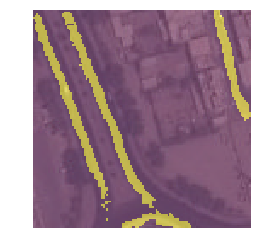

In [65]:
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

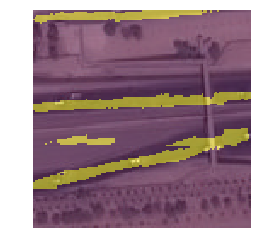

In [66]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

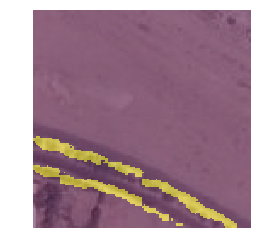

In [70]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

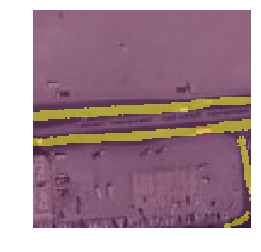

In [76]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

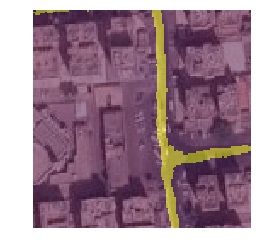

In [77]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

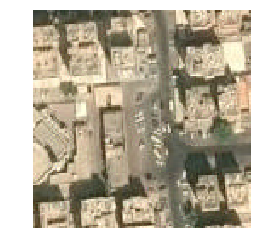

In [78]:
ax = show_img(denorm(x)[0])

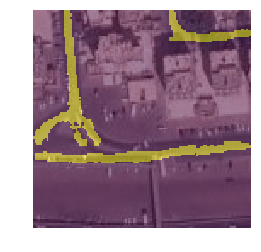

In [79]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

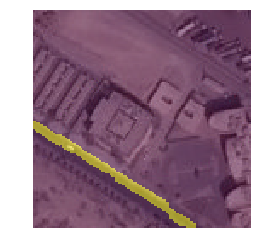

In [81]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

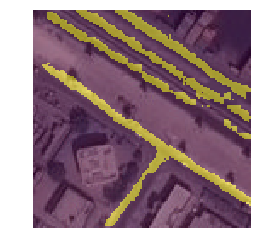

In [84]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

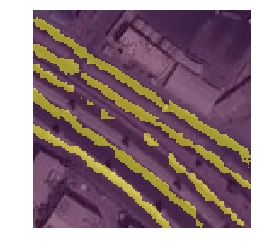

In [86]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

In [98]:
m.close()

In [99]:
learn.save('128-trained')

## 512x512

In [100]:
sz=256
bs=16

In [101]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [102]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [103]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [104]:
learn.freeze_to(1)

In [105]:
learn.load('128-trained')

In [106]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.192087   0.198953   0.924693   0.234957  
    1      0.190137   0.191454   0.924597   0.166331         
    2      0.181021   0.185263   0.924284   0.259345         
    3      0.180283   0.188623   0.925725   0.330981         
    4      0.174362   0.182011   0.925906   0.309078         



[array([0.18201]), 0.9259061079758865, 0.30907772858436805]

In [107]:
learn.save('512urn-tmp')

In [108]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.182182   0.221534   0.921961   0.291489  
    1      0.182574   0.188824   0.923803   0.223919         
    2      0.181125   0.183136   0.925411   0.303422         
    3      0.170654   0.181988   0.926988   0.347597         
    4      0.167553   0.188097   0.925758   0.309144         



[array([0.1881]), 0.9257580830500676, 0.3091437784125392]

In [110]:
learn.save('512urn-tmp-2')

In [111]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
#learn.load('512urn-tmp-3')

In [112]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.16645    0.191249   0.925827   0.389395  
    1      0.163225   0.182507   0.927885   0.368381         
    2      0.156934   0.185779   0.927763   0.366021         
    3      0.156791   0.183001   0.92726    0.356208         
    4      0.148516   0.187861   0.926468   0.309813         
    5      0.150517   0.185427   0.928065   0.395551         
    6      0.145881   0.186413   0.928392   0.349561         
    7      0.141138   0.187226   0.928189   0.358942         



[array([0.18723]), 0.9281891896174504, 0.35894180318549695]

In [113]:
learn.save('512urn')

In [ ]:
it = iter(md.val_dl)

fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    x,y = next(it)
    py = to_np(learn.model(V(x)))

    ax = show_img(denorm(x)[0], ax=ax)
    show_img(py[0]>0, ax=ax, alpha=0.5);
plt.tight_layout(pad=0.1)

# Visualize Results

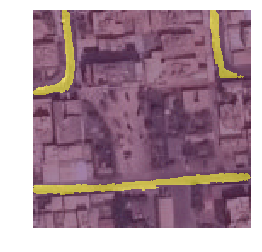

In [122]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

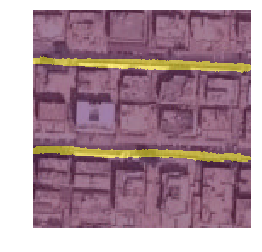

In [124]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

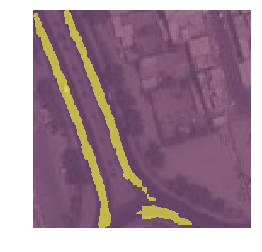

In [125]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

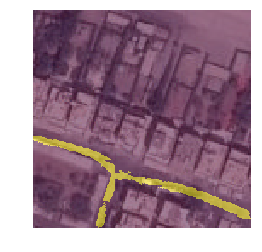

In [131]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

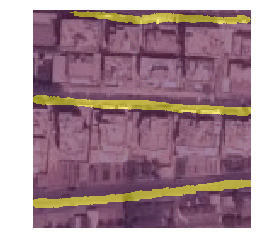

In [134]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

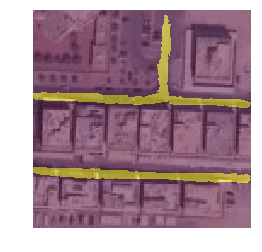

In [142]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

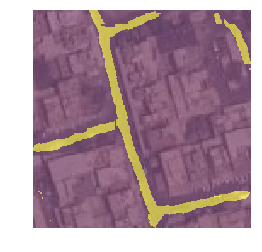

In [143]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

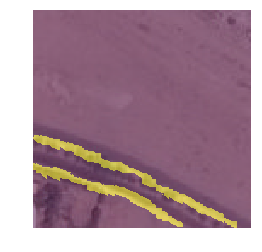

In [145]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

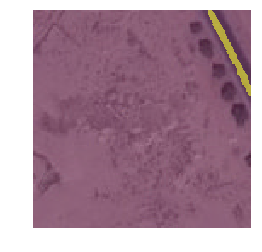

In [146]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

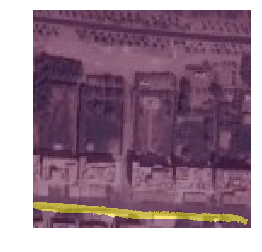

In [147]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

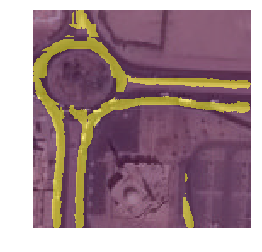

In [187]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

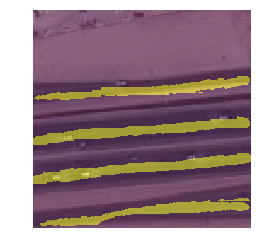

In [196]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

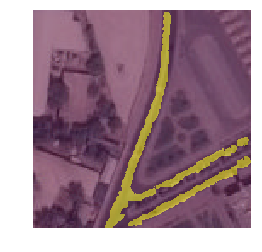

In [208]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

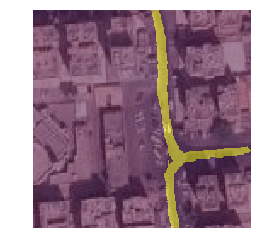

In [210]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

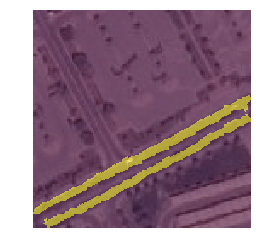

In [231]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

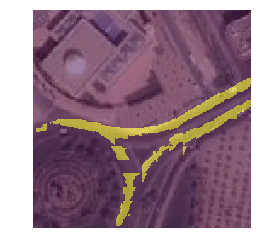

In [239]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

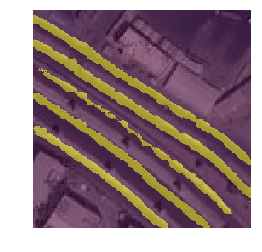

In [242]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

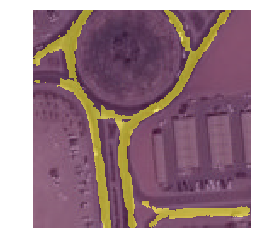

In [248]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

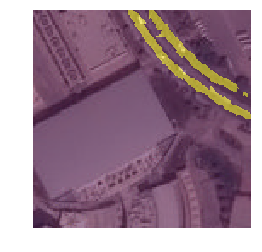

In [254]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

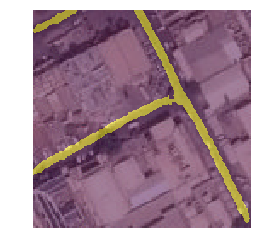

In [268]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

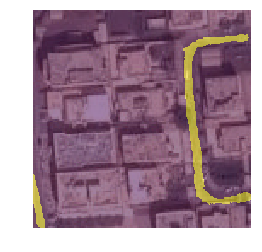

In [273]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

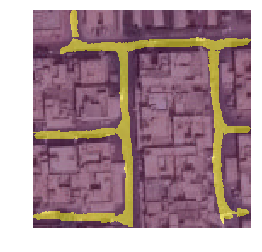

In [277]:
x,y = next(it)
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

In [281]:
m.close()

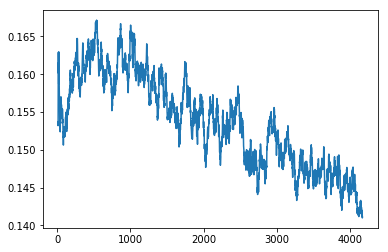

In [282]:
learn.sched.plot_loss()

In [283]:
learn.save('1024urn')